# The Lennard-Jones fluid

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

Ro run the simulation of argon gas

1. initialise poisitions

2. initialise velocities

3. calculate forces and change x and v

4. repeat 3 and store trajectories

What functions we need:

1. position initialiser

$dx=v dt$

2. velocity initialiser

$dv = a dt$

3. force calculator between two particles

We need to find the force from the Lennard-Jones potential.

$F_{i,j}= -\nabla U (r_i-r_j)$

4. potential energy calculator

In [8]:
class Dynamics:
    def __init__(self):
        self.dim = 2
        self.num_particles = 64
        self.positions = np.zeros((self.num_particles,self.dim))
        self.velocities = np.zeros((self.num_particles,self.dim))
        self.mass = 1
        self.T = 1
        self.box_len = 10
        self.k = 1
        self.eps = 1
        self.sigma = 1
        self.dt = 0.001
        self.steps = 2000
        
    def position_init(self):
        self.positions = np.random.random_sample((self.num_particles,self.dim)) * self.box_len
        
    def velocity_init(self):
        factor = math.sqrt(self.k * self.T / self.mass)
        self.velocities = np.random.normal(loc=0,scale=factor,size=(self.num_particles, self.dim))
        
    def lj_force_pair(self,p1, p2):
        # force on p1 due to p2
        r = self.positions[p1] - self.positions[p2]
        r_mag = np.linalg.norm(r)
        r_cap = r/r_mag

        f_mag = 24*self.eps/r_mag * (2*((self.sigma/r_mag)**12) - (self.sigma/r_mag)**6)
        return f_mag * r_cap
        
    def lj_force(self, p):
        force = np.zeros(shape=2)
        for part in range(self.num_particles):
            if(part == p):
                continue
            force += self.lj_force_pair(p, part)
        return force
    
    def euler_integrate(self):
        for i in range(self.steps):
            forces = np.array([self.lj_force(p) for p in range(self.num_particles)])
            self.positions = self.positions + self.velocities*self.dt
            self.velocities = self.velocities + forces*(self.dt/self.mass)
    
    def draw_particles(self):
        plt.figure(figsize=(5,5))
        axis = plt.gca()
        
        axis.set_xlim(-10,self.box_len+10)
        axis.set_ylim(-10,self.box_len+10)

        for i in range(self.num_particles):
            axis.add_patch( plt.Circle(self.positions[i], radius=0.5, 
                                                   linewidth=2, edgecolor='black') )
        plt.show()
        
    def pe_pair(self, p1, p2):
        r = self.positions[p1] - self.positions[p2]
        r_mag = np.linalg.norm(r)
        
        return 4*self.eps*((self.sigma/r_mag)**12 - (self.sigma/r_mag)**6)
    
    def pe(self):
        total_pe = 0.0
        for i in range(self.num_particles):
            for j in range(i+1, self.num_particles):
                total_pe += self.pe_pair(i,j)
        return total_pe
    
    def minimize(self, min_steps, max_dr = 0.15):
        for i in range(min_steps):
            p = np.random.randint(0,self.num_particles)
            dr = np.random.random_sample(size=2)*2*max_dr - max_dr
            pe_bef = self.pe()
            self.positions[p] += dr
            pe_after = self.pe()
            if(pe_bef < pe_after):
                self.positions[p] -= dr

In [9]:
dyn = Dynamics()
dyn.position_init()
dyn.velocity_init()

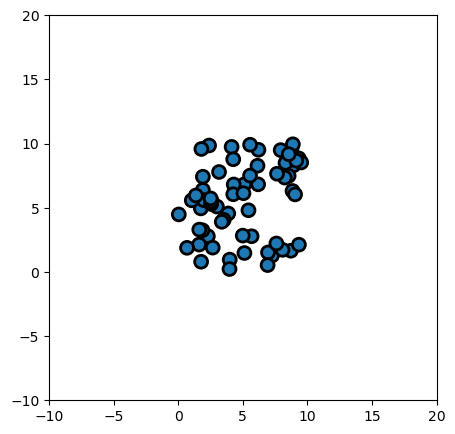

In [10]:
dyn.draw_particles()

In [11]:
dyn.minimize(1000)

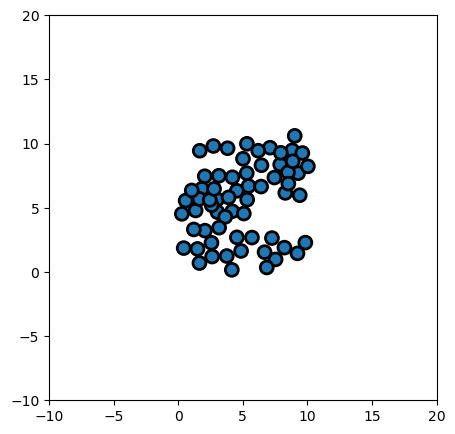

In [12]:
dyn.draw_particles()

In [13]:
dyn.euler_integrate()

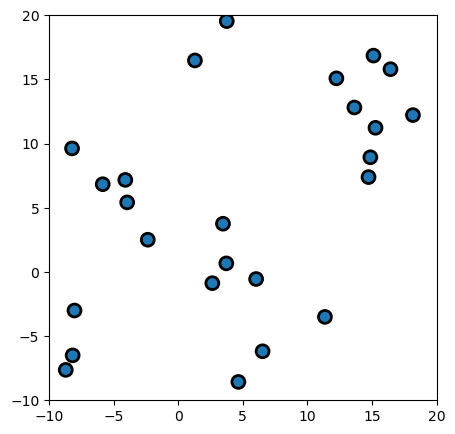

In [14]:
dyn.draw_particles()

## MCMC method:

we will perform the most straightforward Monte Carlo (MC) simulation - a simulation of a Lennard-Jones fluid in the canonical (NVT) ensemble.

The triplet NVT signifies that number of particles, volume (hence, density) and temperature are kept constant during the entire length of this type of simulation.

In this case only the particles are allowed to move, and a random walk is constructed following the approach of Metropolis algorithm, which iterates the following three steps that together constitute a single MC move (or attempt):

1. Select a particle at random and calculate its energ $U(r_1)$.


2. Displace the particle randomly to a trial position and calculate its new energy, $U(r_2)$.


3. Accept or reject the particle displacement according to the Metropolis acceptance rule:

$$
P_{acc} (r_1 \to r_2) = \min(1, \exp{-\beta[U(r_2) - U(r_1)]}) 
$$

where $U(r_2) - U(r_1)$ is the difference between the proposed and current energies, and $\beta$ is the inverse value of the reduced temperature.

#### References:
https://dl_monte.gitlab.io/dl_monte-tutorials-pages/tutorial1.html

https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

### How do we achieve this?


Ensure detailed balance: it is crucial to ensure a truly random (uniform) selection of trial particle positions! Otherwise an unwanted, hidden bias can be introduced into the MC sampling procedure, which would invalidate the obtained statistics.

The common way to move (translate) a particle is to generate a random displacement vector $\delta r$ bound within a cube with a given side legnth $\delta_{max}$ (the so-called displacement parameter) and add it to the current position of the particle under trial.

Then, pick up a random number between 0 and 1 and accept or reject the move as illustrated below:

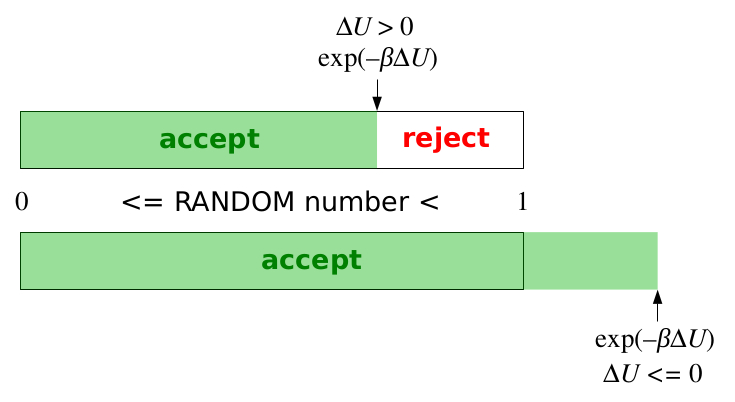